In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sports-image-classification/dataset/sample_submission.csv
/kaggle/input/sports-image-classification/dataset/train.csv
/kaggle/input/sports-image-classification/dataset/test.csv
/kaggle/input/sports-image-classification/dataset/test/730a467265.jpg
/kaggle/input/sports-image-classification/dataset/test/12a9b208fe.jpg
/kaggle/input/sports-image-classification/dataset/test/5e2050af87.jpg
/kaggle/input/sports-image-classification/dataset/test/1deb80beb0.jpg
/kaggle/input/sports-image-classification/dataset/test/72d05ce1b9.jpg
/kaggle/input/sports-image-classification/dataset/test/976e8009cd.jpg
/kaggle/input/sports-image-classification/dataset/test/04b282ddb5.jpg
/kaggle/input/sports-image-classification/dataset/test/b07060a4b2.jpg
/kaggle/input/sports-image-classification/dataset/test/63452153e7.jpg
/kaggle/input/sports-image-classification/dataset/test/90fe17fb0a.jpg
/kaggle/input/sports-image-classification/dataset/test/0f5be6481a.jpg
/kaggle/input/sports-image-classificati

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
df.head()

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket


In [4]:
df.columns

Index(['image_ID', 'label'], dtype='object')

In [5]:
# Import libs
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Prepare Dataset for feature extraction
class SportsImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = self.df['label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'image_ID']
        label = self.df.loc[idx, 'label']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# Transforms for pretrained CNN feature extractor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [8]:
# Transforms for pretrained CNN feature extractor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [9]:
# Create dataset and dataloader for feature extraction
img_dir = '/kaggle/input/sports-image-classification/dataset/train'
dataset = SportsImageDataset(df, img_dir, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [10]:
# Load pretrained ResNet18 for feature extraction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = models.resnet18(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

# Remove the last classification layer so output is features
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [11]:
# Extract features
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        features = feature_extractor(images)
        features = features.view(features.size(0), -1)  # flatten
        features_list.append(features.cpu().numpy())
        labels_list.extend(labels)

In [12]:
X = np.vstack(features_list)
y = np.array(labels_list)

In [13]:
# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [15]:
# Define 5 ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [16]:
# Train & evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = (model, acc)
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.9143
Random Forest Accuracy: 0.8815
SVM Accuracy: 0.9168
Gradient Boosting Accuracy: 0.8773
K-Nearest Neighbors Accuracy: 0.8919


In [17]:
# Find best model
best_model_name = max(results, key=lambda x: results[x][1])
best_model, best_acc = results[best_model_name]

print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")


Best Model: SVM with Accuracy: 0.9168


In [18]:
# Visualize some predictions from best model

# Pick 9 random samples from test set
indices = np.random.choice(len(X_test), size=9, replace=False)
X_vis = X_test[indices]
y_true = y_test[indices]
y_pred = best_model.predict(X_vis)

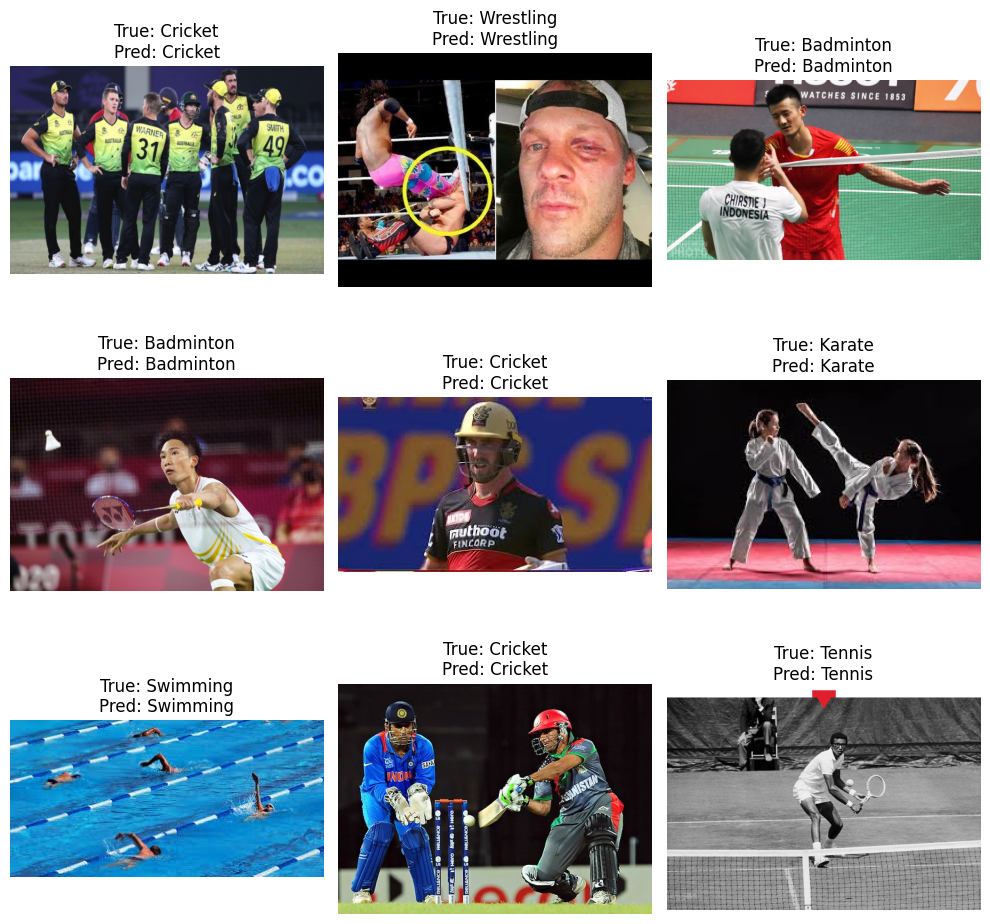

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()

# To show images, we must get their original images using indices on the original df
# Find corresponding original indices in df for test samples
test_indices = []
# We can find these by inverse splitting or keep track during split; here a shortcut:

_, test_indices_all = train_test_split(range(len(X)), test_size=0.2, random_state=42, stratify=y_encoded)
selected_indices_in_df = [test_indices_all[i] for i in indices]

for i, idx in enumerate(selected_indices_in_df):
    img_path = os.path.join(img_dir, df.loc[idx, 'image_ID'])
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {le.inverse_transform([y_true[i]])[0]}\nPred: {le.inverse_transform([y_pred[i]])[0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()